In [25]:
# THIS CODE TAKES IMAGES WITH RANDOM ELLIPSOIDS AND ADDED NOISE, AT THE MINI-PET SCANNER RESOLUTION 
# IT TRAINS A NETWORK WITH THOSE IMAGES AND USES IT TO DENOISE OTHER RANDOM ELLIPSOIDS IMAGES. 
# THE RESULTS ARE COMPARED TO A 10 ITERATION MLEM RECONSTRUCTION OF THE SAME IMAGES AND TO A DENOISING PERFORMED WITH A NETWORK TRAINED WITH MNIST DATABASE IMAGES.

In [26]:
# IMPORT NECESSARY PACKAGES:

import numpy as np 
import odlpet # PET imaging module
import odl # Reconstruction module
import torch # Deep learning package
from torch import nn
from torch.nn import functional as F
from torch import optim # Optimizer package
import torchvision
from torchvision import datasets, transforms # Package to manipulate datasets
import matplotlib.pyplot as plt # Plotting package
torch.manual_seed(123);  # reproducibility
from odlpet.scanner.scanner import Scanner # PET scanner package
from odlpet.scanner.compression import Compression
from odl.contrib.torch import OperatorAsModule # Package to convert ODL operators into PyTorch Tensors
import time 
from odl.contrib import fom # Figures of merit package

In [27]:
# MINI-PET GEOMETRY: JUST A 2D VISION

scanner = Scanner() # Scanner operator

scanner.num_rings = 1 # Number of rings

compression = Compression(scanner) # Compress the scanner
# Acquisition parameters that define the space
compression.max_num_segments = 0 # only direct sinograms
compression.num_of_views = 180 # angle resolution
compression.num_non_arccor_bins = 147 # tangential resolution
compression.data_arc_corrected = True
pet_projector = compression.get_projector(restrict_to_cylindrical_FOV=False) # domain resolution: 35 in z axis, 371 in x,y axis
pet_projector_adj=pet_projector.adjoint

In [28]:
pet_projector_adj=pet_projector.adjoint # Compute adjoint operator
pet_projector.range # Get the range of the PET sinogram space

uniform_discr([   0.,    0., -102.], [   1.    ,    3.1416,  102.    ], (1, 180, 147), dtype='float32')

In [29]:
pet_projector.domain # Get the range of the PET image space

uniform_discr([  0. , -21.9, -21.9], [  0.675,  22.2  ,  22.2  ], (1, 147, 147), dtype='float32')

In [30]:
# Obtain also the conversion into torch tensors for the forward operator and its adjoint
fwd_op_mod=OperatorAsModule(pet_projector)
fwd_op_adj_mod = OperatorAsModule(pet_projector_adj)

In [31]:
def generate_ellipsoids_2d(space,num=np.random.poisson(20),diag=100):
    
    # Generate a 2D phantom of randomly distributed ellipsoids, using for that purpose a "surrounding" space where these ellipsoids are computed and then cropping this "surrounding" space
    # in the center with a size equal to the one given by the reconstruction space. The number of elipsoids is given by "num" and it is usually randomly distributed with a Poisson distribution

    max_axis=diag**2 # Maximum length of the long axis of the ellipsis

    # Surrounding space:
    surround=odl.uniform_discr([0, 0], [int(np.ceil(np.sqrt(max_axis))),int(np.ceil(np.sqrt(max_axis)))], [int(np.ceil(np.sqrt(max_axis))), int(np.ceil(np.sqrt(max_axis)))],
                              dtype='float32') 

    elipse_image=np.zeros((space.shape[1],space.shape[2])) # Accumulator image with all the valid ellipses



    for i in range(num):
        # Propose possible ellipses in a space surrounding the "real PET space". Take into consideration only those ones that fall totally or partially in the "real PET space"
        value=np.random.rand() # Random value for the ellipsis
        angle=np.random.rand()*2*np.pi # Angulation for the elipsis

        if np.sqrt(max_axis)>np.max(pet_projector.domain.shape): # The surrounding space has to be larger than our space
            x_center=2*np.random.rand()-1 # X center of elipsis
            y_center=2*np.random.rand()-1 # Y center of elipsis
            axis1=np.random.exponential(scale=.5) # Long axis of elipsis
            axis2=np.random.exponential(scale=.5) # Short axis of elipsis

            if axis2>axis1: # The short axis of the elipsis should in fact be shorter than the long axis. If the opposite happens, recompute until getting a lower short axis
                while axis2>axis1:
                    axis2=np.random.rand()

            elipse=[[value,axis1, axis2,x_center, y_center,angle]]

            el=odl.phantom.geometric.ellipsoid_phantom(surround, elipse).asarray() # Candidate elipse in the surrounding space

            s=np.sum(el[int(np.sqrt(max_axis/2))-int(pet_projector.domain.shape[1]/2):int(np.sqrt(max_axis)/2)+int(pet_projector.domain.shape[1]/2),int(np.sqrt(max_axis)/2)-int(pet_projector.domain.shape[2]/2):int(np.sqrt(max_axis)/2)+int(pet_projector.domain.shape[2]/2)])
            if s>0: # If the sum is larger than 0, the ellipse is accepted and the counter is increased by one unit

                # Save the elipsoid in an accumulator
                elipse_image+=el[int(np.sqrt(max_axis)/2)-int(pet_projector.domain.shape[1]/2):int(np.sqrt(max_axis)/2)+int(pet_projector.domain.shape[1]/2)+1,int(np.sqrt(max_axis)/2)-int(pet_projector.domain.shape[2]/2):int(np.sqrt(max_axis)/2)+int(pet_projector.domain.shape[2]/2)+1]
        else:
            print('Please introduce a maximum value of the ellipse long axis larger than the size of the reconstruction space in both dimensions')
            break
        
        
    return elipse_image


In [32]:
def ellipse_batch(space, number_of_images,number_of_elipses): # Generate a batch of elipsoid images
    
    images = np.zeros((number_of_images,space.shape[1],space.shape[2])) # Accumulator for the batch with images with different resolution
    
        
        
    for i in range(number_of_images): # Go through all the images you want to generate in the batch
        image = generate_ellipsoids_2d(space,number_of_elipses,200)
        images[i,:,:]=image
        
   
        
    return images 

In [33]:
transformations = transforms.Compose([transforms.ToTensor()]) # Transformations applied on the dataset

from torch.utils.data.dataset import Dataset

# Build a class to construct a PyTorch dataset with the generated random ellipsoid images

class RandomEllipsoids(Dataset):
    def __init__(self,space,num_ellipsoids,diag,train=True,transforms=None):
        """
        Args:
            space: image space where to obtain the dataset of ellipsoid images
            num: number of random ellipsoids
            diag: size of surrounding space used to compute ellipsoids outside the center of the FOV
            num_imag: number of images generated
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.space = pet_projector.domain # Reconstruction space
        self.num_ellipsoids= np.random.poisson(15) # Number of generated ellipsoids in the images
        self.diag = diag # Diagonal applied in image generation
        self.train=train # Set the model to train or validate
        self.transforms = transformations # Transformations to apply on the dataset

    def __getitem__(self,index):
        data=torch.tensor(ellipse_batch(self.space,1,self.num_ellipsoids)) # Call the function producing the batches
        # Transform image to tensor
        #if self.transforms is not None:
            #img_as_tensor = self.transforms(self.data)
        # Return image and the label
        return data

    def __len__(self):
        if self.train==True:
            return 60000 # Size of training dataset
        else:
            return 300 # Size of validation dataset
        

if __name__ == "__main__":
    transformations = transforms.Compose([transforms.ToTensor()]) # Transformations applied on the dataset
    random_ellipsoids = \
        RandomEllipsoids(pet_projector.domain, num_ellipsoids=np.random.poisson(15), diag=100, train=True, transforms=transformations)

In [34]:
# Load training and validation data

# Transformations to execute on the dataset
trafo = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Train and test datasets
dset_train=RandomEllipsoids(pet_projector.domain, num_ellipsoids=np.random.poisson(20), diag=200, train=True,transforms=trafo)
dset_test=RandomEllipsoids(pet_projector.domain, num_ellipsoids=np.random.poisson(20), diag=200, train=False,transforms=trafo)

# Train and test loaders
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=15, shuffle=True)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=15, shuffle=True)



In [35]:
# Class for performing MLEM reconstruction
class MLEM(odl.operator.Operator):
    def __init__(self, op, niter):
        super(MLEM, self).__init__(domain=pet_projector.range, range=pet_projector.domain, linear=True) # Define reconstruction space
        self.op = op # Define reconstruction operator
        self.niter = niter # Define the number of iterations in the reconstruction method
    
    def _call(self, data):
        reco = self.range.one()
        odl.solvers.iterative.statistical.mlem(self.op, reco, data, niter=self.niter) # Reconstruction funtion for MLEM in ODL
        return reco
    

In [36]:
# MLEM operators for comparison and to introduce in the networks, respectively

mlem_op_comp=MLEM(pet_projector,niter=10) # MLEM operator. 10 iterations
mlem_op_comp_mod=OperatorAsModule(mlem_op_comp) # Modified MLEM operator to work with torch tensors

mlem_op_net=MLEM(pet_projector,niter=1) # MLEM operator. 1 iteration
mlem_op_net_mod=OperatorAsModule(mlem_op_net) # Modified MLEM operator to work with torch tensors

In [37]:
# Define the function to obtain noisy sinograms from the datasets

def generate_data(images, operator, noise_level=1.):
    """Create noisy projection data from images.
    
    The data is generated according to ::
        
        data = Poisson(fwd_op(images)/10)
        
    where ``noise`` is standard white noise.
    
    Parameters
    ----------
    images : `Tensor`, shape ``(B, C, 28, 28)``
        Input images for the data generation.
        
    Returns
    -------
    data : `Tensor`, shape ``(B, C, 5, 41)``
        Projection data stack.
    """
    torch.manual_seed(123) # Fix the random generation of noise
    data = operator(images) # Obtain the forward operator for the given images
    #data += torch.randn(data.shape).type_as(data)
    noisy_data = torch.tensor(np.random.poisson(data.cpu()/noise_level)*noise_level) # Poisson distributed random noise over the data
    # Move data to CPU
    return noisy_data

In [38]:
# Define the architecture of the network: U-NET

def double_conv(in_channels, out_channels): # Double convolution + batch normalization + ReLU in each network layer
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),  # 2D convolution
        nn.BatchNorm2d(out_channels), # Batch normalization
        nn.ReLU(inplace=True), # Rectified Linear Unit
        nn.Conv2d(out_channels, out_channels, 3, padding=1), # 2D convolution
        nn.BatchNorm2d(out_channels), # Batch normalization
        nn.ReLU(inplace=True), # Rectified Linear Unit
    )   


class UNet(nn.Module): # Class to define the architecture of the network

    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64) # One input channel, 64 output channels 
        self.dconv_down2 = double_conv(64, 128) # 64 input channels, 128 output channels 
        self.dconv_down3 = double_conv(128, 256) # 128 input channels, 256 output channels 
        self.dconv_down4 = double_conv(256, 512) # 256 input channels, 512 output channels 
        self.dconv_down5 = double_conv(512, 1024) # 512 input channels, 1024 output channels

        self.maxpool = nn.MaxPool2d(2,ceil_mode=True) # 2x pooling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)   # 2x upsampling, with a bilinear interpolation and corner alignment     
        
        self.dconv_up4 = double_conv(512 + 1024, 512) # 512 + 1024 input channels, 512 output channels
        self.dconv_up3 = double_conv(256 + 512, 256) # 256 + 512 input channels, 256 output channels  
        self.dconv_up2 = double_conv(128 + 256, 128) # 128 + 256 input channels, 128 output channels 
        self.dconv_up1 = double_conv(128 + 64, 64) # 128 + 64 input channels, 128 output channels 
        
        self.conv_last = nn.Conv2d(64, 1, 1) # 64 input channels, one output channel and a kernel size of 1 (fully-connected layer)
        
        
    def forward(self, x): # Forward architecture of the designed network
        
        # Downsampling: Convolution + Pooling
        
        # Layer 1
        conv1 = self.dconv_down1(x) 
        x = self.maxpool(conv1)
        
        # Layer 2
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        # Layer 3
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        
        
        # Extra layers: OPTIONAL, if we want to analyze the problem with a network with more layers
        
        #conv4 = self.dconv_down4(x)
        #x = self.maxpool(conv4) 
        
        #x = self.dconv_down3(x)
        
        # Upsampling: Convolution + Upsampling with Bilinear Interpolation
        
        #x = self.upsample(x)
        
        #if x.shape[2]*x.shape[3]==conv4.shape[2]*conv4.shape[3]:
            #x = torch.cat([x, conv4], dim=1)
        #else:
         #   x = torch.cat([F.interpolate(x,size=(conv4.shape[2],conv4.shape[3])), conv4], dim=1)
            
        
        #x = self.dconv_up4(x)
        #x = self.upsample(x)    
        
        #if x.shape[2]*x.shape[3]==conv3.shape[2]*conv3.shape[3]:
        #    x = torch.cat([x, conv3], dim=1)
        #else:
         #    x = torch.cat([F.interpolate(x,size=(conv3.shape[2],conv3.shape[3])), conv3], dim=1)  
        
        # Layer 3
        
        #x = self.dconv_up3(x)
        #x = self.upsample(x)    
        
        if x.shape[2]*x.shape[3]==conv2.shape[2]*conv2.shape[3]:
            x = torch.cat([x, conv2], dim=1)
        else:
             x = torch.cat([F.interpolate(x,size=(conv2.shape[2],conv2.shape[3])), conv2], dim=1)     
        
        # Layer 2
        
        x = self.dconv_up2(x)
        x = self.upsample(x) 
        
        if x.shape[2]*x.shape[3]==conv1.shape[2]*conv1.shape[3]:
            x = torch.cat([x, conv1], dim=1)
        else:
             x = torch.cat([F.interpolate(x,size=(conv1.shape[2],conv1.shape[3])), conv1], dim=1)  
        
        # Layer 1
        
        x = self.dconv_up1(x)
        
        # Output layer
        
        out = self.conv_last(x)

        return out


In [39]:
# Get a batch of test images and generate test projection data
for i,images in enumerate(test_loader):
    if i == 1:
        break

test_images = images # Test images

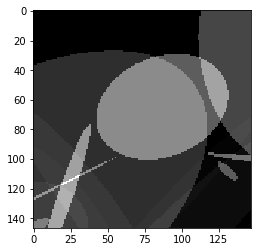

In [40]:
# Visualize some of the images from the validation dataset

plt.figure()
plt.imshow(images[14,0,:,:],cmap='gray')

In [41]:
noise=1/3 # Noise level to introduce in the reconstruction
test_data = generate_data(test_images,fwd_op_mod,noise_level=noise) # Provide noisy test images with Poisson distributed noise

In [42]:
mlem_test_10=mlem_op_comp_mod(test_data) # MLEM reconstruction of the test data with 10 iterations for further comparison
# Normalize dividing by the noise level

Text(0.5, 1.0, 'Test sinogram #1')

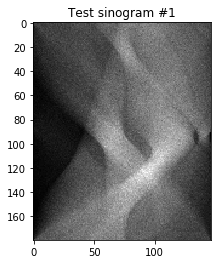

In [43]:
# See the sinograms of the test set

num=0

plt.figure()
plt.imshow(test_data[num,0,:,:].cpu(),cmap='gray')
plt.title('Test sinogram #'+str(num+1))

In [20]:
# DENOISING WITH ELLIPSOIDS:

torch.cuda.empty_cache() # Free some CUDA memory

use_cuda = True
learning_rate = 1.5e-3 # Learning rate for the loss function
log_interval = 200 
epochs = 1 # Number of training iterations
denoise_net = UNet() # Denoising network operator
loss_train = nn.SmoothL1Loss() # Use Mean Squared Error as loss function for the train images (L1 loss)
loss_test = nn.SmoothL1Loss() # Use Mean Squared Error as loss function for the test images (L1 loss)

if use_cuda: # Implement these operators with CUDA
    denoise_net = denoise_net.cuda()
    test_data = test_data.cuda()
    test_images = test_images.cuda()

optimizer = optim.Adam(denoise_net.parameters(), lr=learning_rate) # Use Adam as optimizer for the loss function with the denoising network parameters and the given learning rate

RuntimeError: CUDA error: out of memory

In [44]:
def train(epoch): # Function to perform network training
    denoise_net.train() # Set network to training
    for batch_idx,images in enumerate(train_loader): # Go through all training images according to the different batches used
        if use_cuda:
            images = images.cuda()
        projs = generate_data(images,fwd_op_mod,noise_level=1/3) # Add random Poisson noise to the train images
        noisy_recos = mlem_op_net_mod(projs) # Reconstruct the training images with the noise
        
        optimizer.zero_grad() # Set to zero gradient values for new batches
        output = denoise_net(noisy_recos.cuda()) # Obtain the output of the first forward pass
    
        loss = loss_train(output, images.float()) # Compute the loss function with respect to some Ground Truth or target
        loss.backward() # Start back-propagation
        optimizer.step() # Define some optimizer step
        if batch_idx % log_interval == 0: # Print the progress of the training according to the epoch number, the batch number and the loss function
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}'
                  ''.format(epoch, batch_idx * len(images),
                            len(train_loader.dataset),
                            100. * batch_idx / len(train_loader),
                            loss))
        if batch_idx==len(train_loader)-1:
            return loss.data

def test(): # Obtain test results with the given trained network
    denoise_net.eval() # Set network to evaluation
    
    loss = (loss_test(denoise_net(mlem_op_net_mod(test_data).cuda()), test_images.float())) # Compute loss function with respect to validation images ground truth
    print('\nTest set: Average loss: {:.6f}'.format(loss.data)) # Evaluate accuracy of test set with the loss function, as the targets of the test set are also known
    return loss.data

In [40]:
train_error=[] # Training error values to plot the learning curve from the network
test_error=[] # Validation error values to plot the learning curve from the network

for epoch in range(1, epochs + 1): # Perform training and testing for the given number of epochs
    train_error.append(train(epoch)) # Train the network and compute the training error for the learning curve
    #clear_output()
    test_error.append(test()) # Validate the network and compute the training error for the learning curve

/opt/tljh/user/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Train Epoch: 1 [0/40000 (0%)]	Batch Loss: 0.266645
Train Epoch: 1 [3000/40000 (7%)]	Batch Loss: 0.067670
Train Epoch: 1 [6000/40000 (15%)]	Batch Loss: 0.020859
Train Epoch: 1 [9000/40000 (22%)]	Batch Loss: 0.030547
Train Epoch: 1 [12000/40000 (30%)]	Batch Loss: 0.015595
Train Epoch: 1 [15000/40000 (37%)]	Batch Loss: 0.015900
Train Epoch: 1 [18000/40000 (45%)]	Batch Loss: 0.035491
Train Epoch: 1 [21000/40000 (52%)]	Batch Loss: 0.020758
Train Epoch: 1 [24000/40000 (60%)]	Batch Loss: 0.017256
Train Epoch: 1 [27000/40000 (67%)]	Batch Loss: 0.017325
Train Epoch: 1 [30000/40000 (75%)]	Batch Loss: 0.015191
Train Epoch: 1 [33000/40000 (82%)]	Batch Loss: 0.009427
Train Epoch: 1 [36000/40000 (90%)]	Batch Loss: 0.006059
Train Epoch: 1 [39000/40000 (97%)]	Batch Loss: 0.010517

Test set: Average loss: 0.018968
Train Epoch: 2 [0/40000 (0%)]	Batch Loss: 0.009925
Train Epoch: 2 [3000/40000 (7%)]	Batch Loss: 0.008947
Train Epoch: 2 [9000/40000 (22%)]	Batch Loss: 0.007483
Train Epoch: 2 [12000/40000 (30

Text(0, 0.5, 'Error')

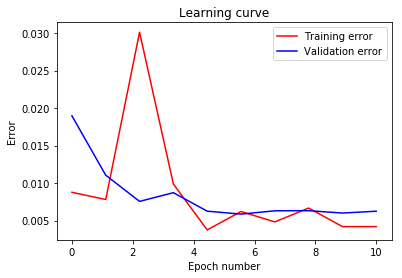

In [41]:
# Learning curve plot
plt.plot(np.linspace(0,epochs,epochs),train_error,'r',label='Training error') # Plotting training error in red
plt.plot(np.linspace(0,epochs,epochs),test_error,'b',label='Validation error') # Plotting validation error in blue
plt.legend()
plt.title('Learning curve')
plt.xlabel('Epoch number')
plt.ylabel('Error')

/opt/tljh/user/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [42]:
# Normalize the test data values so to introduce inputs between -1 and +1 in the network
#test_reco=mlem_op_net_mod(test_data)
#test_reco=(test_reco.cpu()/(torch.tensor(np.max(test_reco.cpu().flatten().numpy()))))


test_res_denoise = denoise_net(mlem_op_net_mod(test_data).cuda()).detach().cpu().numpy() # Obtained denoised results with the given network

In [35]:
# Save checkpoint used in network

# Save the whole model (for further training for example), including the optimizer, in case you want to continue training from a checkpoint
torch.save({
            'epoch': epochs,
            'model_state_dict': denoise_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_train,
            }, 'andres_final_2d_pet_resolution_ellipsoids_all.tar' )

# Save only the model, without the optimizer (not for keep training)
torch.save(denoise_net,'2d_PET_Geometry_ellipsoids_denoise_network.torch')

In [45]:
# Load model checkpoint (just if you need it) UNCOMMENT IT IF YOU WANT TO ACTIVATE IT


learning_rate=1.5e-3 # Learning step rate for Adam optimizer
denoise_net = UNet() # Network architecture
optimizer = optim.Adam(denoise_net.parameters(), lr=learning_rate) # Adam optimizer parameters

checkpoint = torch.load('andres_final_2d_pet_resolution_ellipsoids_all.tar') # Checkpoint file to resume training
denoise_net.load_state_dict(checkpoint['model_state_dict']) # Load model state
optimizer.load_state_dict(checkpoint['optimizer_state_dict']) # Load optimizer state
epochs = checkpoint['epoch'] # Load epochs
loss_train = checkpoint['loss'] # Load loss function

use_cuda = True # Perform further training on GPU

if use_cuda: # Implement these operators with CUDA
    denoise_net = denoise_net.cuda()

denoise_net.train() # Set the architecture to training

RuntimeError: CUDA out of memory. Tried to allocate 36.00 MiB (GPU 0; 11.91 GiB total capacity; 294.29 MiB already allocated; 12.06 MiB free; 216.00 KiB cached)

In [21]:
#denoise_net= denoise_net.to(cuda)
# Move to GPU also the loaded optimizer parameters
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

In [24]:
use_cuda = True 

if use_cuda: # Implement these operators with CUDA
    denoise_net = denoise_net.cuda()

epochs=5 # Number of training iterations
log_interval=50 # Frequency of progress display in the network

# Train with loaded model
train_error=[] # Training errors to display in learning curve
test_error=[] # Validation errors to display in learning curve

for epoch in range(1, epochs + 1): # Perform training and testing for the given number of epochs
    train_error.append(train(epoch)) # Train the network and compute the training errors for the learning curve in each epoch
    #clear_output()
    test_error.append(test()) # Validate the network and compute the validation errors for the learning curve in each epoch

RuntimeError: CUDA out of memory. Tried to allocate 79.25 MiB (GPU 0; 11.91 GiB total capacity; 273.50 MiB already allocated; 40.06 MiB free; 1.00 MiB cached)

In [25]:
# Denoise the testing set with the already trained network

test_res_denoise = denoise_net(mlem_op_net_mod(test_data).cuda()).detach().cpu().numpy() # Obtained denoised results with the given network

Text(0.5, 1.0, 'Test image profile #2')

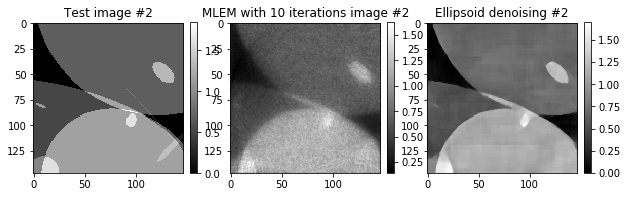

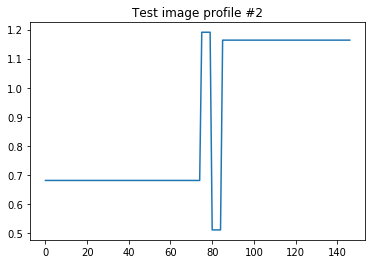

In [69]:
# RESULT VISUALIZATION

num=2 # Image to visualize


plt.figure(figsize=(10,20))

# Ground truth
plt.subplot(131)
plt.imshow(test_images[num,0,:,:].cpu(),cmap='gray')
plt.title('Test image #'+str(num))
plt.colorbar(fraction=0.046, pad=0.04)

# 10 iterations MLEM
plt.subplot(132)
plt.imshow(mlem_test_10[num,0,:,:].cpu(),cmap='gray')
plt.title('MLEM with 10 iterations image #'+str(num))
plt.colorbar(fraction=0.046, pad=0.04)

# Denoising result with ellipsoids network
plt.subplot(133)
plt.imshow(test_res_denoise[num,0,:,:],cmap='gray')
plt.title('Ellipsoid denoising #'+str(num))
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure()
plt.plot(range(test_images.cpu().numpy().shape[2]),test_images.cpu().numpy().squeeze()[num,0:test_images.cpu().numpy().shape[2],int(test_images.cpu().numpy().shape[3]/2)])
plt.title('Test image profile #'+str(num))

In [67]:
# LOAD MNIST DATASET FOR TRAINING

dset_train_mnist = datasets.MNIST('./data', train=True, download=True, transform=trafo) # Download the MNIST images (handwritten numbers) for training as PyTorch tensors
train_loader_mnist = torch.utils.data.DataLoader(dset_train_mnist, batch_size=50, shuffle=True) # Load the MNIST images with a batch size of 50 and shuffling

# Validation data for MNIST dataset (unused)

#dset_test_mnist = datasets.MNIST('./data', train=False, transform=trafo) # Obtain MNIST images (handwritten numbers) for testing as PyTorch tensors
#test_loader_mnist = torch.utils.data.DataLoader(dset_test, batch_size=50, shuffle=True) # Load the test images with a batch size of 50 (50 images tested per iteration) and shuffle them after every iteration

In [68]:
# Prepare the MNIST forward operator and MLEM reconstruction operator

space_mnist = odl.uniform_discr([-14, -14], [14, 14], [28, 28], dtype='float32') # Discretized space for the MNIST images, which defines their resolution (28x28)
#geometry = odl.tomo.parallel_beam_geometry(space, num_angles=5)
geometry_mnist = odl.tomo.parallel_beam_geometry(space_mnist, num_angles=54) # Define the geometry. In this case, parallel-beam with 54 views
fwd_op_mnist = odl.tomo.RayTransform(space_mnist, geometry_mnist) # Define the forward operator as the Radon Transform
fwd_op_mnist_mod=OperatorAsModule(fwd_op_mnist) # Forward operator to work with tensors

In [69]:
# Class for performing MLEM reconstruction in MNIST images
class MLEM_mnist(odl.operator.Operator):
    def __init__(self, op, niter):
        super(MLEM_mnist, self).__init__(domain=fwd_op_mnist.range, range=fwd_op_mnist.domain, linear=True) # Reconstruction space for MNIST training images
        self.op = op # MLEM reconstruction operator
        self.niter = niter # Number of iterations
    
    def _call(self, data):
        reco = self.range.one() # Reconstruction space
        odl.solvers.iterative.statistical.mlem(self.op, reco, data, niter=self.niter) # ODL reconstruction function for MLEM
        return reco

In [70]:
# MLEM reconstruction operators for MNIST images

mlem_op_net_mnist=MLEM_mnist(fwd_op_mnist,niter=1) # MLEM operator. 1 iteration
mlem_op_net_mnist_mod=OperatorAsModule(mlem_op_net_mnist) # Modified MLEM operator to work with torch tensors

In [71]:
torch.cuda.empty_cache() # Save some CUDA memory

use_cuda = True # Work with the network in the GPU
learning_rate = 1.5e-3 # Learning rate for the loss function
log_interval = 200 # Frequency of progress display for the network
epochs = 10 # Number of training iterations
denoise_net_mnist = UNet() # Denoising network operator
loss_train = nn.SmoothL1Loss() # Use Mean Squared Error as loss function for the train images (L1 loss)
loss_test = nn.SmoothL1Loss() # Use Mean Squared Error as loss function for the test images (L1 loss)

#if use_cuda: # Implement these operators with CUDA
    #denoise_net = denoise_net.cuda()
    #test_data = test_data.cuda()
    #test_images = test_images.cuda()

optimizer = optim.Adam(denoise_net.parameters(), lr=learning_rate) # Use Adam as optimizer for the loss function with the denoising network parameters and the given learning rate


def train_mnist(epoch): # Function to perform network training
    denoise_net_mnist.train() # Set network to training
    for batch_idx,images_mnist in enumerate(train_loader_mnist): # Go through all training images according to the different batches used
        if use_cuda:
            images_mnist = images_mnist[0].cuda() # Move network input images to the GPU
        projs = generate_data(images_mnist,fwd_op_mnist_mod,noise_level=1/3) # Add random Poisson noise to the train images
        noisy_recos = mlem_op_net_mnist_mod(projs) # Reconstruct the training images with the noise
        optimizer.zero_grad() # Clear the gradient results in the optimizer
        output = denoise_net_mnist(noisy_recos) # Obtain the output of the first forward pass
        loss = loss_train(output, images_mnist.float().cpu()) # Compute the loss function with respect to some Ground Truth or target
        loss.backward() # Start back-propagation
        optimizer.step() # Define some optimizer step
        if batch_idx % log_interval == 0: # Print the progress of the training according to the epoch number, the batch number and the loss function
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}'
                  ''.format(epoch, batch_idx * len(images_mnist),
                            len(train_loader_mnist.dataset),
                            100. * batch_idx / len(train_loader_mnist),
                            loss))
        if batch_idx==len(train_loader_mnist)-1:
            return loss.data # Save training error values

def test_mnist(): # Obtain test results with the given trained network
    denoise_net_mnist.eval() # Set network to evaluation
    
    loss = (loss_test(denoise_net_mnist(mlem_op_net_mod(test_data).cpu().float()), test_images.cpu().float())) # Loss function with respect to validation ground truth
    print('\nTest set: Average loss: {:.6f}'.format(loss.data)) # Evaluate accuracy of test set with the loss function, as the targets of the test set are also known
    return loss.data

In [72]:
train_mnist_error=[] # Training errors on MNIST network
test_mnist_error=[] # Validation errors on MNIST network

for epoch in range(1, epochs + 1): # Perform training and testing for the given number of epochs
    train_mnist_error.append(train_mnist(epoch)) # Complete training and compute training errors
    #clear_output()
    test_mnist_error.append(test_mnist()) # Complete validation and compute validation errors

Train Epoch: 1 [0/60000 (0%)]	Batch Loss: 0.081558
Train Epoch: 1 [10000/60000 (17%)]	Batch Loss: 0.073428
Train Epoch: 1 [20000/60000 (33%)]	Batch Loss: 0.077801
Train Epoch: 1 [30000/60000 (50%)]	Batch Loss: 0.084788
Train Epoch: 1 [40000/60000 (67%)]	Batch Loss: 0.080798
Train Epoch: 1 [50000/60000 (83%)]	Batch Loss: 0.078591

Test set: Average loss: 1.068037
Train Epoch: 2 [0/60000 (0%)]	Batch Loss: 0.088499
Train Epoch: 2 [10000/60000 (17%)]	Batch Loss: 0.081627
Train Epoch: 2 [20000/60000 (33%)]	Batch Loss: 0.081037
Train Epoch: 2 [30000/60000 (50%)]	Batch Loss: 0.079962
Train Epoch: 2 [40000/60000 (67%)]	Batch Loss: 0.073918
Train Epoch: 2 [50000/60000 (83%)]	Batch Loss: 0.084139

Test set: Average loss: 1.057271
Train Epoch: 3 [0/60000 (0%)]	Batch Loss: 0.087720
Train Epoch: 3 [10000/60000 (17%)]	Batch Loss: 0.081804
Train Epoch: 3 [20000/60000 (33%)]	Batch Loss: 0.081266
Train Epoch: 3 [30000/60000 (50%)]	Batch Loss: 0.079477
Train Epoch: 3 [40000/60000 (67%)]	Batch Loss: 0.07

Text(0, 0.5, 'Error')

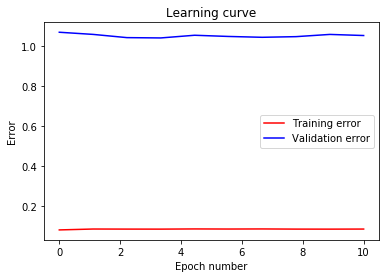

In [73]:
# Learning curve plot
plt.plot(np.linspace(0,epochs,epochs),train_mnist_error,'r',label='Training error') # Plotting training error in red
plt.plot(np.linspace(0,epochs,epochs),test_mnist_error,'b',label='Validation error') # Plotting validation error in blue
plt.legend()
plt.title('Learning curve')
plt.xlabel('Epoch number')
plt.ylabel('Error')

In [34]:
# Save the whole model (for further training for example), including optimizer steps
torch.save({
            'epoch': epochs,
            'model_state_dict': denoise_net_mnist.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_train,
            }, 'denoiser_2d_pet_resolution_mnist.tar' )

# Save only model, without optimizer parameters (not suitable for resume training)
torch.save(denoise_net_mnist,'2d_PET_Geometry_ellipsoids_denoise_network_mnist.torch')

NameError: name 'denoise_net_mnist' is not defined

In [ ]:
# Load model checkpoint (just if you need it) UNCOMMENT IT IF YOU WANT TO ACTIVATE IT

#denoise_net = UNet() # Network architecture
#optimizer = optim.Adam(denoise_net_mnist.parameters(), lr=learning_rate) # Optimizer parameters

#checkpoint = torch.load('denoiser_2d_pet_resolution_ellipsoids.tar') # Load checkpoint to resume training
#denoise_net.load_state_dict(checkpoint['model_state_dict']) # Load model state
#optimizer.load_state_dict(checkpoint['optimizer_state_dict']) # Load optimizer state
#epochs = checkpoint['epoch'] # Load epochs
#loss_train = checkpoint['loss'] # Load loss

#denoise_net_mnist.train() # Set network training

In [74]:

test_reco=mlem_op_net_mod(test_data) # Reconstruct testing data

test_res_denoise_mnist = denoise_net_mnist(test_reco.cpu()).detach().cpu().numpy() # Obtained denoised results with the given network


# Set to 0 negative values, both for MNIST and ellipsoids networks
ind_0=np.where(test_res_denoise_mnist<0)
test_res_denoise_mnist[ind_0]=0.0

ind_0=np.where(test_res_denoise<0)
test_res_denoise[ind_0]=0.0

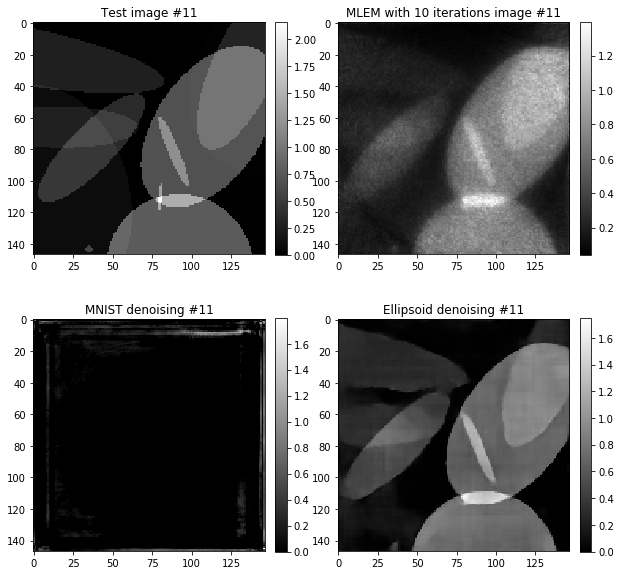

In [90]:
# RESULT VISUALIZATION WITH BOTH NETWORKS

num=10 # Image to visualize


plt.figure(figsize=(10,10))

# Ground truth
plt.subplot(221)
plt.imshow(test_images[num,0,:,:].cpu(),cmap='gray')
plt.title('Test image #'+str(num+1))
plt.colorbar(fraction=0.046, pad=0.04)

# 10 iterations MLEM reconstruction
plt.subplot(222)
plt.imshow(mlem_test_10[num,0,:,:].cpu(),cmap='gray')
plt.title('MLEM with 10 iterations image #'+str(num+1))
plt.colorbar(fraction=0.046, pad=0.04)

# Denoising with MNIST network
plt.subplot(223)
plt.imshow(test_res_denoise_mnist[num,0,:,:],cmap='gray')
plt.title('MNIST denoising #'+str(num+1))
plt.colorbar(fraction=0.046, pad=0.04)

# Denoising with ellipsoids network
plt.subplot(224)
plt.imshow(test_res_denoise[num,0,:,:],cmap='gray')
plt.title('Ellipsoid denoising #'+str(num+1))
plt.colorbar(fraction=0.046, pad=0.04)



In [51]:
# NORMALIZATION OF IMAGES (show their profiles under the same dynamic range)
test_images_norm=np.copy(test_images.cpu().numpy().squeeze())
mlem_10_norm=np.copy(mlem_test_10.cpu().numpy().squeeze())
denoised_norm=np.copy(test_res_denoise.squeeze())
#denoised_norm_mnist=np.copy(test_res_denoise_mnist.squeeze())

# Normalize the images, but remove them that could be empty, to avoid dividing by zero
index=[]
for i in range(test_images.shape[0]):
    if np.amax(test_images_norm[i,:,:].flatten())!=0:
        #test_images_norm[i,:,:]=test_images_norm[i,:,:]/np.amax(test_images_norm[i,:,:].flatten())
        #mlem_10_norm[i,:,:]=mlem_10_norm[i,:,:]/np.amax(mlem_10_norm[i,:,:].flatten())
        #denoised_norm[i,:,:]=denoised_norm[i,:,:]/np.amax(denoised_norm[i,:,:].flatten())
        index.append(i)
    #else:
        #test_images_norm[i,:,:]=np.zeros((test_images_norm.shape[1],test_images_norm.shape[2]))
        #mlem_10_norm[i,:,:]=np.zeros((test_images_norm.shape[1],test_images_norm.shape[2]))
        #denoised_norm[i,:,:]=np.zeros((test_images_norm.shape[1],test_images_norm.shape[2]))
        


In [79]:
print(ind)

NameError: name 'ind' is not defined

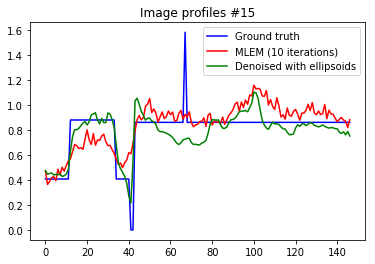

In [66]:
# Central profile display

num=14 # Select image number to display


plt.figure()
plt.plot(range(test_images_norm.shape[2]),test_images_norm[num,0:test_images_norm.shape[1],int(test_images_norm.shape[2]/2)],'b',label='Ground truth') # Ground truth
plt.title('Image profiles #'+str(num+1))
plt.plot(range(test_images_norm.shape[2]),mlem_10_norm[num,0:test_images_norm.shape[1],int(test_images_norm.shape[2]/2)],'r',label='MLEM (10 iterations)') # 10 iteration MLEM
plt.plot(range(test_images_norm.shape[2]),denoised_norm[num,0:test_images_norm.shape[1],int(test_images_norm.shape[2]/2)].squeeze(),'g',label='Denoised with ellipsoids') # Ellipsoid denoising
#plt.plot(range(test_images_norm.shape[2]),denoised_norm_mnist[num,0:test_images_norm.shape[1],int(test_images_norm.shape[2]/2)].squeeze(),'k',label='Denoised with MNIST') # MNIST denoising
plt.legend()

In [32]:
def peak_SNR(img,ground_truth):
    # Compute the peak SNR between an image and its ground truth
    
    # Normalization: make both images have a maximum value of 1
    img=torch.tensor(img/np.amax(img.flatten()))
    ground_truth=torch.tensor(ground_truth/np.amax(ground_truth.flatten()))
    
    mse=nn.MSELoss() # Define the Mean Square Error
    return -10*np.log10(mse(img,ground_truth.float())) # PSNR main expression for computation

In [33]:
# EVALUATE RESULTS WITH FIGURES OF MERIT

# Structural similarity index (SSIM) calculation

mlem_ssim=fom.ssim(mlem_10_norm[index,:,:],test_images_norm[index,:,:]) # SSIM for the MLEM reconstructed images
#mnist_ssim=fom.ssim(test_res_denoise_mnist.squeeze(),test_images.cpu().numpy().squeeze()) # SSIM for the denoised images with the MNIST network
ellipses_ssim=fom.ssim(denoised_norm[index,:,:],test_images_norm[index,:,:]) # SSIM for the denoised images with the ellipsoid network

# Peak Signal-to-Noise Ratio computation

mlem_psnr=peak_SNR(mlem_10_norm[index,:,:],test_images_norm[index,:,:]) # SSIM for the MLEM reconstructed images
#mnist_psnr=peak_SNR(test_res_denoise_mnist.squeeze(),test_images.cpu().numpy().squeeze()) # SSIM for the denoised images with the MNIST network
ellipses_psnr=peak_SNR(denoised_norm[index,:,:],test_images_norm[index,:,:]) # SSIM for the denoised images with the ellipsoid network

# Value printing

print('\nSSIM for MLEM reconstructed images with 10 iterations: {}'.format(mlem_ssim))
#print('\nSSIM for denoised images with MNIST network: {}'.format(mnist_ssim))
print('\nSSIM for denoised images with ellipsoids network: {}\n'.format(ellipses_ssim))

print('\nPSNR for MLEM reconstructed images with 10 iterations: {}'.format(mlem_psnr))
#print('\nPSNR for denoised images with MNIST network: {}'.format(mnist_psnr))
print('\nPSNR for denoised images with ellipsoids network: {}\n'.format(ellipses_psnr))


SSIM for MLEM reconstructed images with 10 iterations: 0.9430460181326118

SSIM for denoised images with ellipsoids network: 0.9841591924387472


PSNR for MLEM reconstructed images with 10 iterations: 25.890697479248047

PSNR for denoised images with ellipsoids network: 30.74925422668457



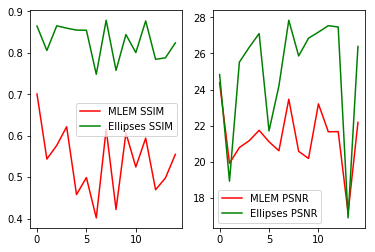

In [67]:
# Evaluate the SSIM and the PSNR image by image

mlem_ssim_list=[] # 10 iterations MLEM reconstruction SSIM value
mnist_ssim_list=[] # Denoising network with MNIST SSIM value
ellipses_ssim_list=[] # Denoising network with ellipsoids SSIM value

mlem_psnr_list=[] # 10 iterations MLEM reconstruction PSNR value
#mnist_psnr_list=[] # Denoising network with MNIST SSIM value
ellipses_psnr_list=[] # Denoising network with ellipsoids SSIM value

for i in range(test_images_norm.shape[0]): # Go image by image computing the FOM values
    mlem_ssim_list.append(fom.ssim(mlem_10_norm[i,:,:],test_images_norm[i,:,:]))
    ellipses_ssim_list.append(fom.ssim(denoised_norm[i,:,:],test_images_norm[i,:,:]))
    #mnist_ssim_list.append(fom.ssim(denoised_norm_mnist[i,:,:],test_images_norm[i,:,:]))
    mlem_psnr_list.append(peak_SNR(mlem_10_norm[i,:,:],test_images_norm[i,:,:]))
    ellipses_psnr_list.append(peak_SNR(denoised_norm[i,:,:],test_images_norm[i,:,:]))
    #mnist_psnr_list.append(peak_SNR(denoised_norm_mnist[i,:,:],test_images_norm[i,:,:]))
    

plt.figure()

# Graph with SSIM values
plt.subplot(1,2,1)
plt.plot(range(test_images_norm.shape[0]),mlem_ssim_list,'r',label='MLEM SSIM')
plt.plot(range(test_images_norm.shape[0]),ellipses_ssim_list,'g',label='Ellipses SSIM')
#plt.plot(range(test_images_norm.shape[0]),mnist_ssim_list,'k',label='MNIST SSIM')
plt.legend()

# Graph with PSNR values
plt.subplot(1,2,2)
plt.plot(range(test_images_norm.shape[0]),mlem_psnr_list,'r',label='MLEM PSNR')
plt.plot(range(test_images_norm.shape[0]),ellipses_psnr_list,'g',label='Ellipses PSNR')
#plt.plot(range(test_images_norm.shape[0]),mnist_psnr_list,'k',label='MNIST PSNR')
plt.legend()